In [51]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("FILTERED"),index_col=0)


In [52]:
clinical_df = pd.read_csv(os.getenv("CLINICAL"))

In [53]:
# Sanity check — how many match?
matching = clinical_df["sample_id"].isin(df.index).sum()
print(f"Matching samples: {matching} / {len(clinical_df)}")


Matching samples: 3409 / 3409


In [54]:
# Set title as index
clinical_df_indexed = clinical_df.set_index("sample_id")

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


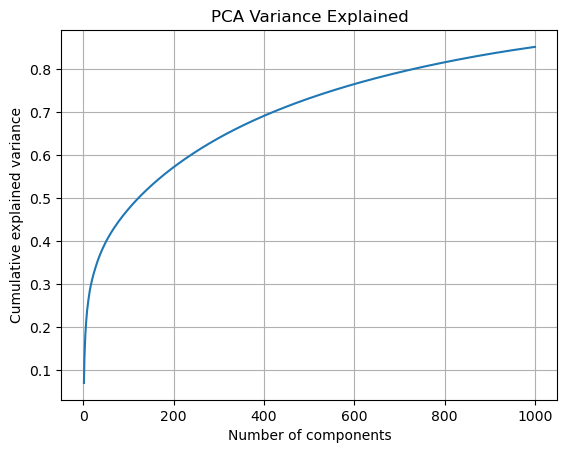

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)  # start big
X_pca = pca.fit_transform(df)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Variance Explained")
plt.grid(True)
plt.show()


In [56]:
from sklearn.decomposition import PCA

# 2-component PCA for visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(df)

print(f"Explained variance ratio (2D): {pca2.explained_variance_ratio_}")
print(f"Cumulative variance: {pca2.explained_variance_ratio_.sum():.2%}")


Explained variance ratio (2D): [0.07104903 0.05516014]
Cumulative variance: 12.62%


In [57]:
# Check variance per gene
gene_variances = df.var()

# How many genes have almost no variance?
low_variance_genes = (gene_variances < 1e-5).sum()
print(f"Number of near-zero variance genes: {low_variance_genes} / {df.shape[1]}")


Number of near-zero variance genes: 0 / 26150


In [58]:
print("Top 5 most variable genes:")
print(gene_variances.sort_values(ascending=False).head())


Top 5 most variable genes:
JC037706    122.333380
DQ597485     94.250676
DQ584545     92.155895
DQ572382     79.880566
DQ590013     67.822257
dtype: float64


Available columns containing 'pam50':
['pam50 subtype__Basal', 'pam50 subtype__Her2', 'pam50 subtype__LumA', 'pam50 subtype__LumB', 'pam50 subtype__Normal']


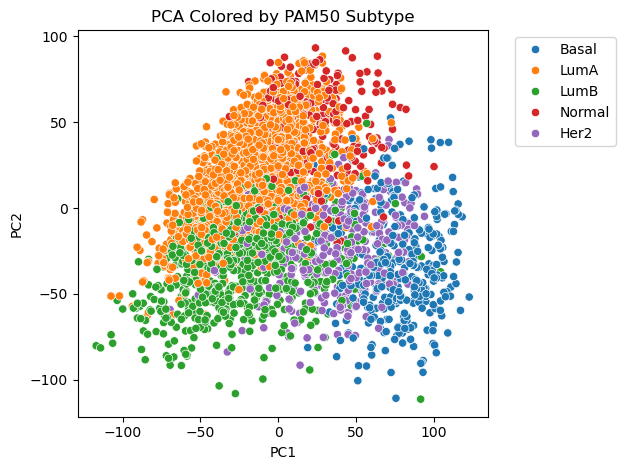

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Set 'title' as index in clinical_df
clinical_df_indexed = clinical_df.set_index("sample_id")

# Step 2: Create PCA DataFrame using expression_df's index (which should match title)
pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=expression_df.index)

# Step 3: Join PCA results with clinical metadata
pca_df = pca_df.join(clinical_df_indexed)

# Step 4: Check available columns
print("Available columns containing 'pam50':")
pam50_cols = [col for col in clinical_df_indexed.columns if 'pam50' in col.lower()]
print(pam50_cols)

# Convert one-hot encoded PAM50 subtype back to categorical
subtype_cols = [col for col in clinical_df_indexed.columns if col.startswith("pam50 subtype__")]
if subtype_cols:
    # Create a categorical column from one-hot encoding
    pam50_subtype = clinical_df_indexed[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")
    pca_df['pam50_subtype'] = pam50_subtype
    
    # Plot PCA colored by subtype
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="pam50_subtype", palette="tab10")
    plt.title("PCA Colored by PAM50 Subtype")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No PAM50 subtype columns found!")
    print("Available columns:", clinical_df_indexed.columns.tolist())


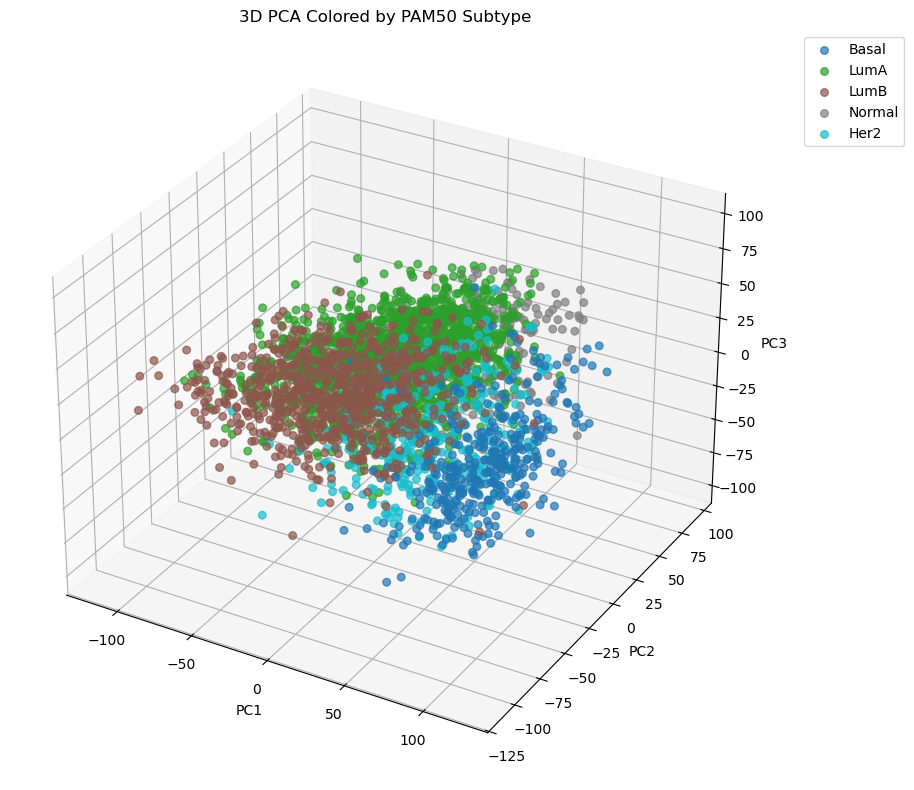

In [60]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 50 components (or use n_components_90 as discussed)
pca = PCA(n_components=3)
X_pca_kmeans = pca.fit_transform(expression_df)

# Set number of clusters (e.g. 5, since we have 5 subtypes)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_kmeans)

# First, make sure we have PC3 in our dataframe
if 'PC3' not in pca_df.columns:
    # Add PC3 from the PCA results
    pca_df['PC3'] = X_pca[:, 2]  # Third principal component

# Create a 3D PCA visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique subtypes and colors
if 'pam50_subtype' in pca_df.columns:
    subtypes = pca_df['pam50_subtype'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(subtypes)))
    
    for i, subtype in enumerate(subtypes):
        mask = pca_df['pam50_subtype'] == subtype
        ax.scatter(pca_df.loc[mask, 'PC1'], 
                  pca_df.loc[mask, 'PC2'], 
                  pca_df.loc[mask, 'PC3'], 
                  c=[colors[i]], 
                  label=subtype, 
                  alpha=0.7,
                  s=30)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA Colored by PAM50 Subtype')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("PAM50 subtype column not available for 3D plot")


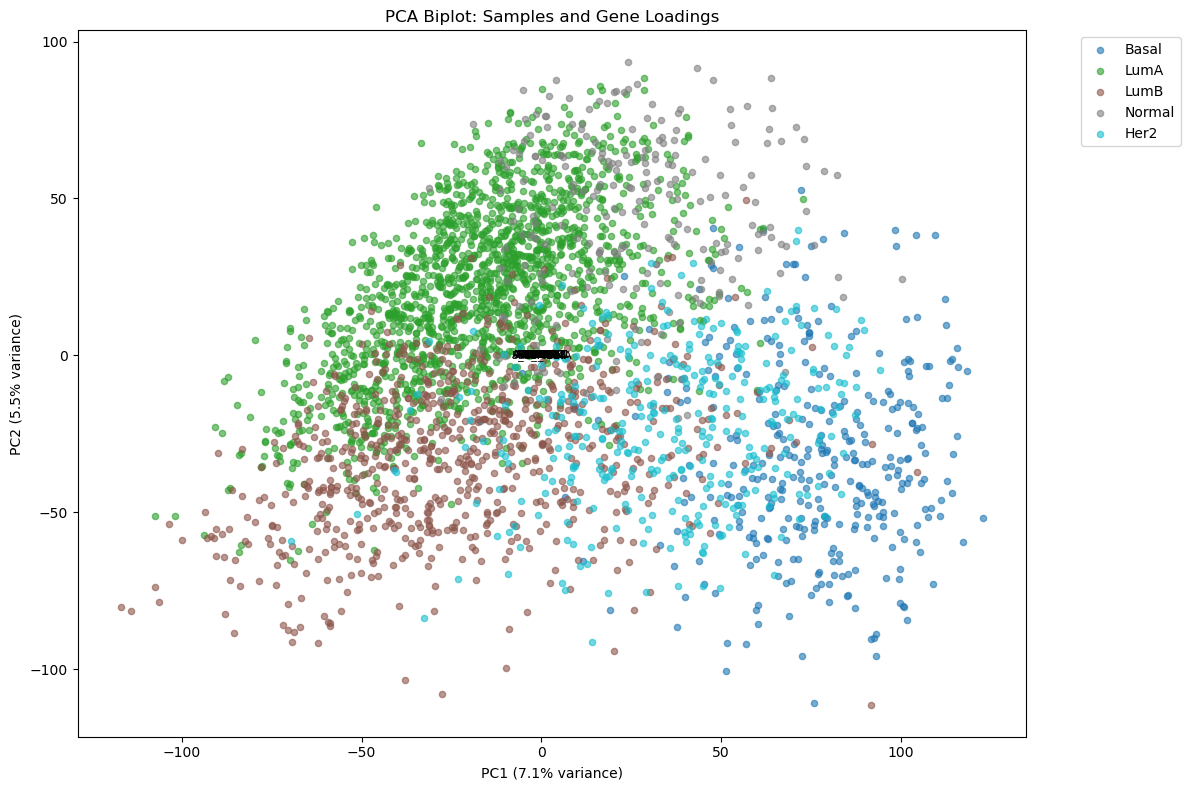

In [61]:
pca_df["Cluster"] = cluster_labels  # assumes pca_df indexed by sample_id/title

# PCA Biplot with features and samples
def biplot(pca_data, pca_model, features, labels=None, pc1=0, pc2=1):
    """
    Create a biplot showing both samples and feature loadings
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot samples
    if labels is not None and 'pam50_subtype' in labels.columns:
        subtypes = labels['pam50_subtype'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(subtypes)))
        
        for i, subtype in enumerate(subtypes):
            mask = labels['pam50_subtype'] == subtype
            ax.scatter(pca_data[mask, pc1], pca_data[mask, pc2], 
                      c=[colors[i]], label=subtype, alpha=0.6, s=20)
    else:
        ax.scatter(pca_data[:, pc1], pca_data[:, pc2], alpha=0.6, s=20)
    
    # Plot feature loadings (arrows)
    loadings = pca_model.components_
    feature_names = features[:20]  # Show top 20 features to avoid crowding
    
    for i, feature in enumerate(feature_names):
        ax.arrow(0, 0, loadings[pc1, i]*3, loadings[pc2, i]*3, 
                head_width=0.5, head_length=0.5, fc='red', ec='red', alpha=0.7)
        ax.text(loadings[pc1, i]*3.2, loadings[pc2, i]*3.2, feature, 
               fontsize=8, ha='center', va='center')
    
    ax.set_xlabel(f'PC{pc1+1} ({pca_model.explained_variance_ratio_[pc1]:.1%} variance)')
    ax.set_ylabel(f'PC{pc2+1} ({pca_model.explained_variance_ratio_[pc2]:.1%} variance)')
    ax.set_title('PCA Biplot: Samples and Gene Loadings')
    
    if labels is not None and 'pam50_subtype' in labels.columns:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Create biplot with PAM50 subtype labels
if 'pam50_subtype' in pca_df.columns:
    sample_labels = pca_df[['pam50_subtype']]
    biplot(X_pca, pca, expression_df.columns, sample_labels)
else:
    print("Creating biplot without subtype labels")
    biplot(X_pca, pca, expression_df.columns)


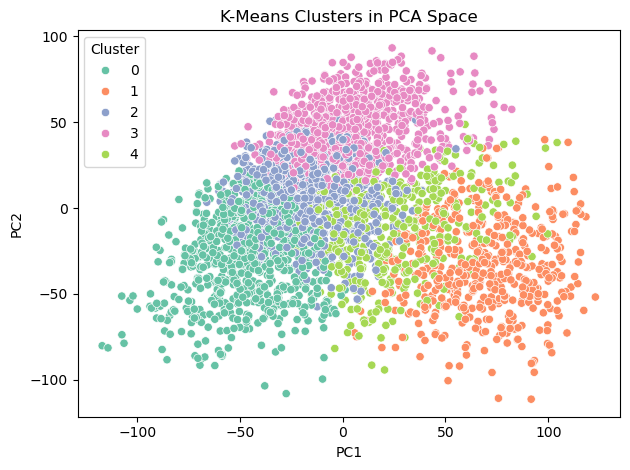

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("K-Means Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [63]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(pca_df["pam50_subtype"], pca_df["Cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.3f}")


Adjusted Rand Index (ARI): 0.223


## Remove Outliers

n_clusters=2: Silhouette=0.239, ARI with PAM50=0.333
n_clusters=3: Silhouette=0.184, ARI with PAM50=0.322
n_clusters=4: Silhouette=0.189, ARI with PAM50=0.349
n_clusters=4: Silhouette=0.189, ARI with PAM50=0.349
n_clusters=5: Silhouette=0.157, ARI with PAM50=0.258
n_clusters=5: Silhouette=0.157, ARI with PAM50=0.258
n_clusters=6: Silhouette=0.160, ARI with PAM50=0.279
n_clusters=6: Silhouette=0.160, ARI with PAM50=0.279
n_clusters=7: Silhouette=0.156, ARI with PAM50=0.270
n_clusters=7: Silhouette=0.156, ARI with PAM50=0.270


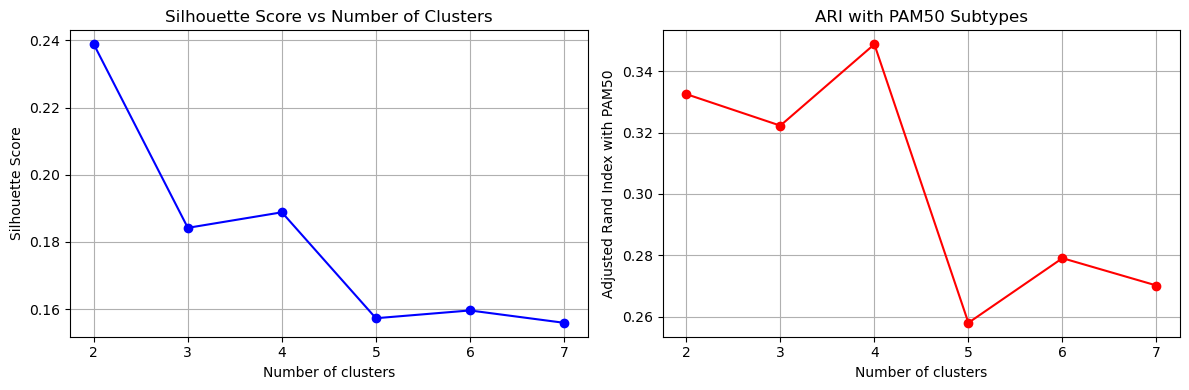


Optimal clustering with 5 clusters:
Silhouette Score: 0.157
ARI with PAM50: 0.258

Crosstab between PAM50 subtypes and clusters:
Cluster          0    1    2    3    4
PAM50_Subtype                         
Basal            8  317    4   30    1
Her2             7    7   61  267    6
LumA           631    0  761   66  251
LumB             8    1  206  175  377
Normal         173    3   15   32    2


In [64]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Compute z-scores across each gene (column-wise)
z_scores = df.apply(zscore, axis=0)

# Get max absolute z-score per sample
max_abs_z_per_sample = z_scores.abs().max(axis=1)

# Parameters
z_threshold = 10
max_allowed_extreme_genes = 10  # tweak this as needed

# Count number of extreme genes per sample
n_extreme_per_sample = (z_scores.abs() > z_threshold).sum(axis=1)

# Filter samples with acceptable number of outlier genes
df_filtered = df[n_extreme_per_sample <= max_allowed_extreme_genes]

# Clustering analysis on PCA-reduced data
# Try different numbers of clusters
n_clusters_range = range(2, 8)
silhouette_scores = []
ari_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca[:, :10])  # Use first 10 PCs
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_pca[:, :10], cluster_labels)
    silhouette_scores.append(sil_score)
    
    # Calculate ARI with PAM50 subtypes if available
    if 'pam50_subtype' in pca_df.columns:
        true_labels = pca_df['pam50_subtype']
        # Convert to numeric labels for ARI calculation
        le = LabelEncoder()
        true_labels_numeric = le.fit_transform(true_labels)
        ari = adjusted_rand_score(true_labels_numeric, cluster_labels)
        ari_scores.append(ari)
    
    print(f"n_clusters={n_clusters}: Silhouette={sil_score:.3f}", end="")
    if 'pam50_subtype' in pca_df.columns:
        print(f", ARI with PAM50={ari:.3f}")
    else:
        print()

# Plot the scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(n_clusters_range, silhouette_scores, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Number of Clusters')
ax1.grid(True)

if ari_scores:
    ax2.plot(n_clusters_range, ari_scores, 'ro-')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Adjusted Rand Index with PAM50')
    ax2.set_title('ARI with PAM50 Subtypes')
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'PAM50 subtypes not available\nfor ARI calculation', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('ARI with PAM50 Subtypes')

plt.tight_layout()
plt.show()

# Perform clustering with optimal number of clusters (5 for PAM50)
optimal_clusters = 5
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_pca[:, :10])

print(f"\nOptimal clustering with {optimal_clusters} clusters:")
print(f"Silhouette Score: {silhouette_score(X_pca[:, :10], cluster_labels_optimal):.3f}")

if 'pam50_subtype' in pca_df.columns:
    true_labels_numeric = le.fit_transform(pca_df['pam50_subtype'])
    ari_optimal = adjusted_rand_score(true_labels_numeric, cluster_labels_optimal)
    print(f"ARI with PAM50: {ari_optimal:.3f}")
    
    # Show confusion between clusters and PAM50 subtypes
    comparison_df = pd.DataFrame({
        'PAM50_Subtype': pca_df['pam50_subtype'],
        'Cluster': cluster_labels_optimal
    })
    print("\nCrosstab between PAM50 subtypes and clusters:")
    print(pd.crosstab(comparison_df['PAM50_Subtype'], comparison_df['Cluster']))


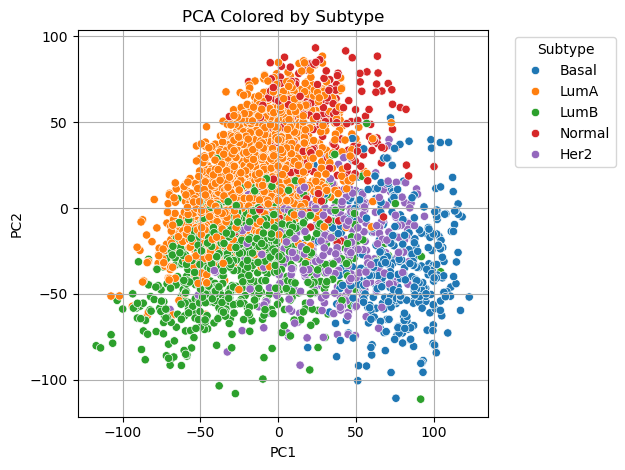

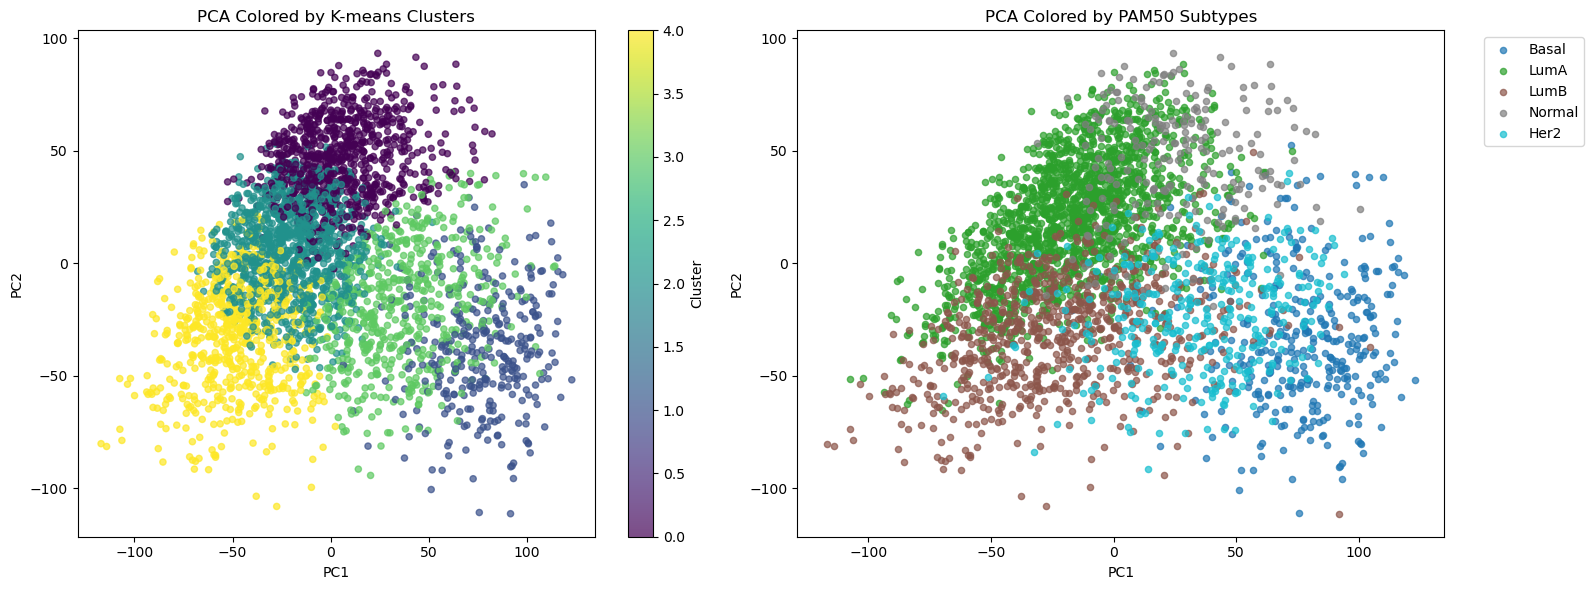


=== PCA Analysis Summary ===
Total samples: 3409
Total features (genes): 26150
PCA components used: 1000
Variance explained by first 3 PCs: 15.6%

PAM50 Subtype distribution:
pam50_subtype
Basal      360
Her2       348
LumA      1709
LumB       767
Normal     225
Name: count, dtype: int64

Clustering performance:
- Silhouette Score: 0.157
- ARI with PAM50: 0.258

Cluster-subtype correspondence:
Cluster          0    1    2    3    4
PAM50_Subtype                         
Basal            8  317    4   30    1
Her2             7    7   61  267    6
LumA           631    0  761   66  251
LumB             8    1  206  175  377
Normal         173    3   15   32    2
- Silhouette Score: 0.157
- ARI with PAM50: 0.258

Cluster-subtype correspondence:
Cluster          0    1    2    3    4
PAM50_Subtype                         
Basal            8  317    4   30    1
Her2             7    7   61  267    6
LumA           631    0  761   66  251
LumB             8    1  206  175  377
Normal     

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(df_filtered)



# Step 4: Plot PCA colored by subtype (adjust column name if needed)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="pam50_subtype", palette="tab10")
plt.title("PCA Colored by Subtype")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final visualization: PCA plot showing both clusters and PAM50 subtypes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by clusters
scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels_optimal, 
                      cmap='viridis', alpha=0.7, s=20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA Colored by K-means Clusters')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: Colored by PAM50 subtypes (if available)
if 'pam50_subtype' in pca_df.columns:
    subtypes = pca_df['pam50_subtype'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(subtypes)))
    
    for i, subtype in enumerate(subtypes):
        mask = pca_df['pam50_subtype'] == subtype
        ax2.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                   c=[colors[i]], label=subtype, alpha=0.7, s=20)
    
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('PCA Colored by PAM50 Subtypes')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    ax2.text(0.5, 0.5, 'PAM50 subtypes not available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('PAM50 Subtypes (Not Available)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== PCA Analysis Summary ===")
print(f"Total samples: {pca_df.shape[0]}")
print(f"Total features (genes): {expression_df.shape[1]}")
print(f"PCA components used: {X_pca.shape[1]}")
print(f"Variance explained by first 3 PCs: {pca.explained_variance_ratio_[:3].sum():.1%}")

if 'pam50_subtype' in pca_df.columns:
    print(f"\nPAM50 Subtype distribution:")
    print(pca_df['pam50_subtype'].value_counts().sort_index())
    
    print(f"\nClustering performance:")
    print(f"- Silhouette Score: {silhouette_score(X_pca[:, :10], cluster_labels_optimal):.3f}")
    print(f"- ARI with PAM50: {ari_optimal:.3f}")
    
    print(f"\nCluster-subtype correspondence:")
    comparison_df = pd.DataFrame({
        'PAM50_Subtype': pca_df['pam50_subtype'],
        'Cluster': cluster_labels_optimal
    })
    crosstab = pd.crosstab(comparison_df['PAM50_Subtype'], comparison_df['Cluster'])
    print(crosstab)


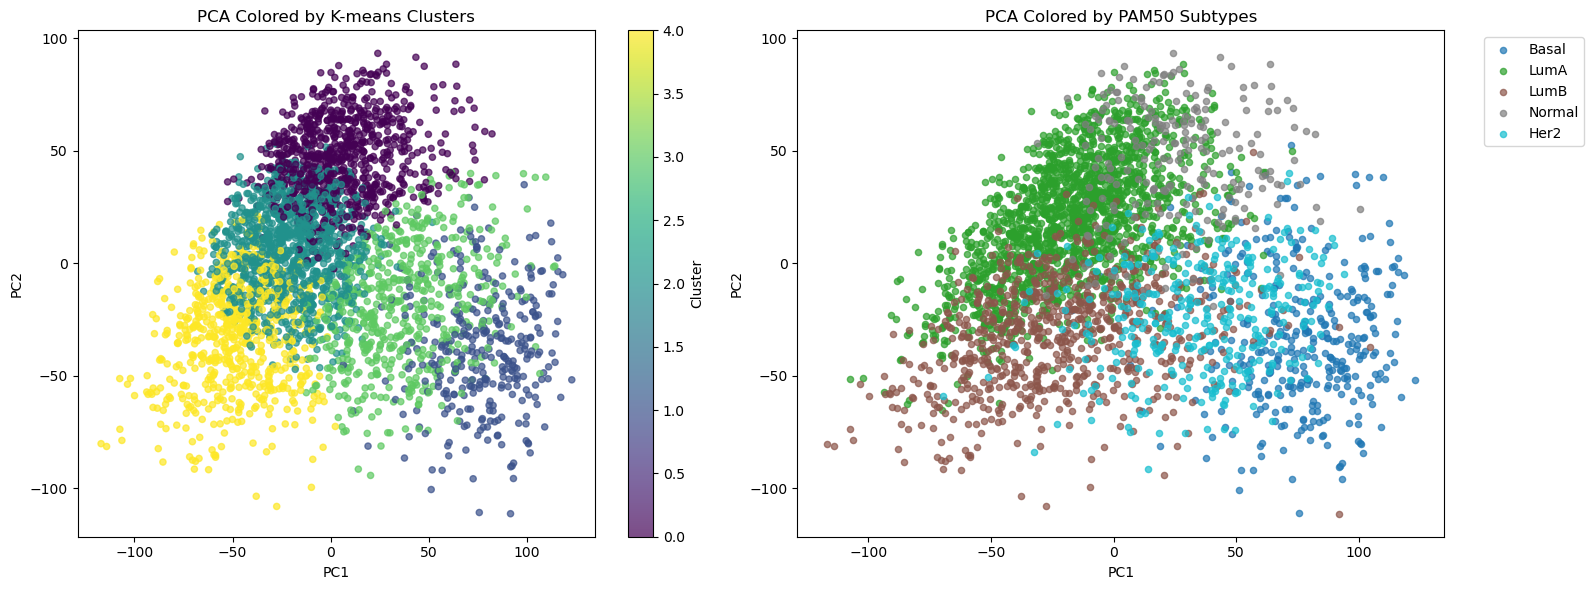


=== PCA Analysis Summary ===
Total samples: 3409
Total features (genes): 26150
PCA components used: 1000
Variance explained by first 3 PCs: 15.6%

PAM50 Subtype distribution:
pam50_subtype
Basal      360
Her2       348
LumA      1709
LumB       767
Normal     225
Name: count, dtype: int64

Clustering performance:
- Silhouette Score: 0.157
- ARI with PAM50: 0.258

Cluster-subtype correspondence:
Cluster          0    1    2    3    4
PAM50_Subtype                         
Basal            8  317    4   30    1
Her2             7    7   61  267    6
LumA           631    0  761   66  251
LumB             8    1  206  175  377
Normal         173    3   15   32    2


In [67]:
# Final visualization: PCA plot showing both clusters and PAM50 subtypes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by clusters
scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels_optimal, 
                      cmap='viridis', alpha=0.7, s=20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA Colored by K-means Clusters')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: Colored by PAM50 subtypes (if available)
if 'pam50_subtype' in pca_df.columns:
    subtypes = pca_df['pam50_subtype'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(subtypes)))
    
    for i, subtype in enumerate(subtypes):
        mask = pca_df['pam50_subtype'] == subtype
        ax2.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                   c=[colors[i]], label=subtype, alpha=0.7, s=20)
    
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('PCA Colored by PAM50 Subtypes')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    ax2.text(0.5, 0.5, 'PAM50 subtypes not available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('PAM50 Subtypes (Not Available)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== PCA Analysis Summary ===")
print(f"Total samples: {pca_df.shape[0]}")
print(f"Total features (genes): {expression_df.shape[1]}")
print(f"PCA components used: {X_pca.shape[1]}")
print(f"Variance explained by first 3 PCs: {pca.explained_variance_ratio_[:3].sum():.1%}")

if 'pam50_subtype' in pca_df.columns:
    print(f"\nPAM50 Subtype distribution:")
    print(pca_df['pam50_subtype'].value_counts().sort_index())
    
    print(f"\nClustering performance:")
    print(f"- Silhouette Score: {silhouette_score(X_pca[:, :10], cluster_labels_optimal):.3f}")
    print(f"- ARI with PAM50: {ari_optimal:.3f}")
    
    print(f"\nCluster-subtype correspondence:")
    comparison_df = pd.DataFrame({
        'PAM50_Subtype': pca_df['pam50_subtype'],
        'Cluster': cluster_labels_optimal
    })
    crosstab = pd.crosstab(comparison_df['PAM50_Subtype'], comparison_df['Cluster'])
    print(crosstab)